<a href="https://colab.research.google.com/github/pradeep2005s2/datasets/blob/master/CNN_using_covid19_chest_xray_impages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Pradeep Kumar S |  
email: pradeep2005s1@gmail.com

Related persenation on CNN concpets: https://docs.google.com/presentation/d/1IsWDxshgr22H7srv6wz61CC8kewEJEYeiu3SeAfOlDQ/edit#slide=id.p

### Import Libraries

In [2]:
#import libraries requried for CNN and other general libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt


### Download data

In [5]:
#clone git data directory and make it available in google drive
#original sources continiously updated: https://github.com/ieee8023/covid-chestxray-dataset
#Kaggle processed source : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
! git clone https://github.com/pradeep2005s2/datasets.git

Cloning into 'datasets'...
remote: Enumerating objects: 2301, done.
remote: Total 2301 (delta 0), reused 0 (delta 0), pack-reused 2301
Receiving objects: 100% (2301/2301), 1.31 GiB | 40.82 MiB/s, done.
Checking out files: 100% (2295/2295), done.


In [ ]:
#connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/datasets/Data')

In [6]:
import os
base_dir = '/content/datasets/Data'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test')

train_covid_dir = os.path.join(train_dir,'COVID19')
test_covid_dir = os.path.join(test_dir,'COVID19')

train_normal_dir = os.path.join(train_dir,'NORMAL')
test_normal_dir = os.path.join(test_dir, 'NORMAL')

In [7]:
train_covid_names = os.listdir(train_covid_dir)
print(len(train_covid_names[:]))

train_normal_names = os.listdir(train_normal_dir)
print(len(train_normal_names[:]))

test_covid_names = os.listdir(test_covid_dir)
print(len(test_covid_names[:]))

test_normal_names = os.listdir(test_normal_dir)
print(len(test_normal_names[:]))

print("total train",len(train_covid_names[:]) + len(train_normal_names[:]) )
print("total test",len(test_covid_names[:]) + len(test_normal_names[:]) )

545
1266
167
317
total train 1811
total test 484


### Image Visualization

['/content/datasets/Data/train/COVID19/COVID19(331).jpg', '/content/datasets/Data/train/COVID19/COVID19(487).jpg', '/content/datasets/Data/train/COVID19/COVID-19 (342).jpg', '/content/datasets/Data/train/COVID19/COVID19(66).jpg', '/content/datasets/Data/train/COVID19/COVID19(156).jpg', '/content/datasets/Data/train/COVID19/COVID19(256).jpg', '/content/datasets/Data/train/COVID19/COVID19(327).jpg', '/content/datasets/Data/train/COVID19/COVID19(365).jpg']
['/content/datasets/Data/train/NORMAL/NORMAL(875).jpg', '/content/datasets/Data/train/NORMAL/NORMAL(56).jpg', '/content/datasets/Data/train/NORMAL/NORMAL(553).jpg', '/content/datasets/Data/train/NORMAL/NORMAL(804).jpg', '/content/datasets/Data/train/NORMAL/NORMAL(571).jpg', '/content/datasets/Data/train/NORMAL/NORMAL(608).jpg', '/content/datasets/Data/train/NORMAL/NORMAL(1393).jpg', '/content/datasets/Data/train/NORMAL/NORMAL(408).jpg']


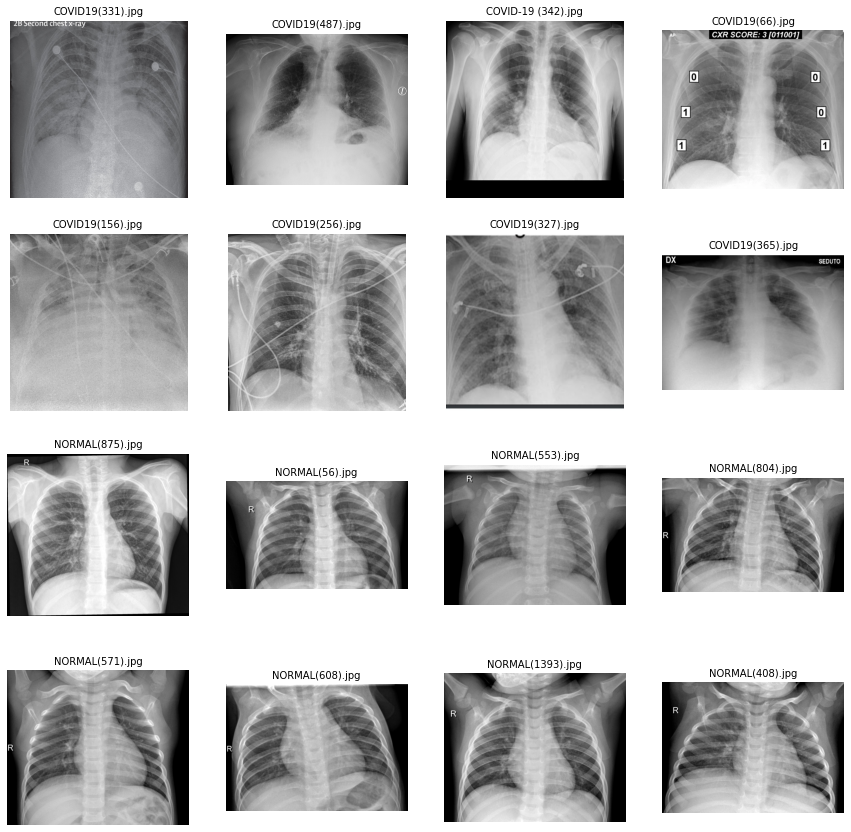

In [8]:
import matplotlib.image as mpimg

nrows = 4
ncols = 4


fig = plt.gcf() #get current figure
fig.set_size_inches(15,15)

# get paths of 8 images for each - covid and normal
next_covid_pic = [os.path.join(train_covid_dir,fname) for fname in train_covid_names[0:8]]
next_normal_pic = [os.path.join(train_normal_dir, fname) for fname in train_normal_names[0:8]]

print(next_covid_pic)
print(next_normal_pic)

for i, img_path in enumerate(next_covid_pic+next_normal_pic):
  #image and image_name
  image_name = img_path.split('/')[-1]
  img = mpimg.imread(img_path)
  #set display properties
  sp = plt.subplot(nrows,ncols, i+1)
  sp.axis('off')
  sp.set_title(image_name, fontsize=10)
  #image display
  plt.imshow(img,cmap='gray')

plt.show()

### Image augmentation - generate more data set

In [9]:
#split trianing and test sets

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, horizontal_flip=True)
validation_datagen=ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory( train_dir, 
                                                    target_size = (150,150),
                                                    subset='training',
                                                    batch_size=32,
                                                    class_mode = 'binary')

validation_generator = train_datagen.flow_from_directory( train_dir, 
                                                    target_size = (150,150),
                                                    subset='validation',
                                                    batch_size=32,
                                                    class_mode = 'binary')

test_generator = test_datagen.flow_from_directory( test_dir, 
                                                    target_size = (150,150),
                                                    batch_size=32,
                                                    class_mode = 'binary')

Found 1449 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 484 images belonging to 2 classes.


In [10]:
train_generator.class_indices #image classes

{'COVID19': 0, 'NORMAL': 1}

In [11]:
train_generator.image_shape #image dim and channel

(150, 150, 3)

### Build CNN
Visalize CNN: https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html 
MNIST handwritten digits prediction: http://yann.lecun.com/exdb/mnist/

#### Filters and image processing examples

In [12]:
edge_detection_fitler = [-1,-1,-1,-1,8,-1,-1,-1,-1]
sharpen_filter = [0,-1,0,-1,5,-1,0,-1,0]
blur_filter = [1,1,1,1,1,1,1,1,1]

# https://colab.research.google.com/drive/1ch-e1TTpjDSodc7RM8_aoXCRNNYS9LGS#scrollTo=tTJqPuWAyc_O

#### Activation functions visualiation: https://dashee87.github.io/deep%20learning/visualising-activation-functions-in-neural-networks/

#### Architecture of CNN
* Input >>
* Conv block1: Conv > ReLU > MaxPooling > Dropout >>
* Conv block2: Conv > Relu > MaxPooling > Dropout > Flatten >>
* Fully connected block: Dense > ReLU > Dropout >> 
* Output: Dense > binary-sigmoid

In [13]:
model = Sequential()

#Conv block1:
model.add(Conv2D(32,(5,5),padding='SAME', activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

#Conv block2:
model.add(Conv2D(64,(5,5),padding='SAME', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())

#Fully connected block
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))

#Output block:
model.add(Dense(1,activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0

### Training the model

##### ADAM (adaptive moment estimation) : https://towardsdatascience.com/adam-optimization-algorithm-1cdc9b12724a

Original paper: https://arxiv.org/pdf/1412.6980.pdf

In [14]:
#compile the model with optimizer and loss function and performance metrics
model.compile(Adam(lr=0.001),loss='binary_crossentropy', metrics=['accuracy'])

#Train the model
history = model.fit( train_generator,
                    epochs=5, #all data once through the network 1000 / batchsize = 10 = 100 batches per epoch
                    validation_data = validation_generator,
                    validation_steps = 10 # approx = validation_gen size / batch size
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/2
46/46 [==============================] - 68s 831ms/step - loss: 0.4367 - accuracy: 0.8716 - val_loss: 0.2117 - val_accuracy: 0.9344
Epoch 2/2
46/46 [==============================] - 38s 820ms/step - loss: 0.1332 - accuracy: 0.9462 - val_loss: 0.1277 - val_accuracy: 0.9625


###Test the model and Peformance evaluation 

In [15]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epoch')

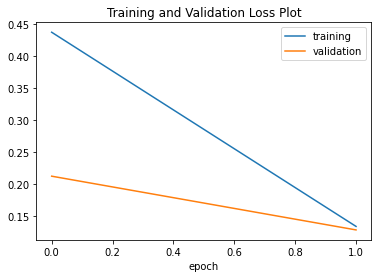

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Training and Validation Loss Plot')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

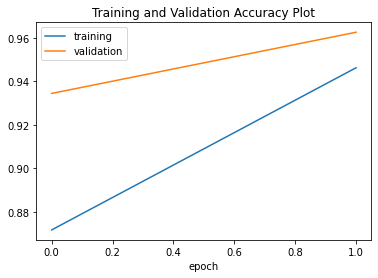

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Training and Validation Accuracy Plot')
plt.xlabel('epoch')

In [ ]:
#Train the model
history2 = model.fit(train_generator,
                    epochs=50, #all data once through the network 1000 / batchsize = 10 = 100 batches per epoch
                    validation_data=validation_generator,
                    validation_steps = 10 # approx = validation_gen size / batch size
)

Epoch 1/50
46/46 [==============================] - 39s 851ms/step - loss: 0.1149 - accuracy: 0.9614 - val_loss: 0.1157 - val_accuracy: 0.9656
Epoch 2/50
46/46 [==============================] - 38s 825ms/step - loss: 0.0888 - accuracy: 0.9669 - val_loss: 0.1147 - val_accuracy: 0.9563
Epoch 3/50
46/46 [==============================] - 37s 814ms/step - loss: 0.0658 - accuracy: 0.9752 - val_loss: 0.0935 - val_accuracy: 0.9656
Epoch 4/50
40/46 [=========================>....] - ETA: 4s - loss: 0.0734 - accuracy: 0.9761

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Training and Validation Loss Plot with epoch = 20')
plt.xlabel('epoch')

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Training and Validation Accuracy Plot with epoch = 20')
plt.xlabel('epoch')

In [ ]:
#valuation on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print('test_accuracy : {} test_loss : {}' .format(test_accuracy, test_loss))

### Prediction on the new data

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
for fn in uploaded.keys():
  path='/content/'+fn
  print(path)
  img = image.load_img(path, target_size=(150,150)) # preprocess uploaded image
  x = image.img_to_array(img)
  x=np.expand_dims(x,axis=0)
  images=np.vstack([x])
  classes = model.predict(images,batch_size=10) # model prediction
  print(fn)
  if classes==0:
    print('Covid19')
  else:
    print('Normal')

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f11536a49e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 
Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f11536a49e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


### Save the model >> cloud or Android App

In [ ]:
from google.colab import files
files.download('model.h5')